In [39]:
import pandas as pd
import matplotlib.patches as mpatches
from scipy import stats
import os.path
import matplotlib.pyplot as plt
import numpy as np
import math
from datetime import datetime, timedelta
from sklearn import decomposition

In [2]:
traindf=pd.read_csv("train.csv")
memberdf=pd.read_csv("members.csv")
traindf=traindf.merge(memberdf,on='msno',how='inner')
traindf=traindf.replace({'male':0.0,'female':1.0})
traindf['gender']=traindf['gender'].fillna(-1.0)

In [3]:
trainzchurn=traindf[traindf['is_churn']==0]
trainochurn=traindf[traindf['is_churn']==1]

In [5]:
maxread=4e6
uselogdf=pd.read_csv("user_logs.csv",nrows=maxread)


In [6]:
uselogdf['DateTime'] = uselogdf['date'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
uselogdf=uselogdf.sort_values(['msno', 'DateTime'], ascending=[True,False])
uselogdf['count'] = uselogdf.groupby('msno')['msno'].transform('count')
cols = ['msno']+list(uselogdf.loc[:,'num_25':'count'])
sumdat=uselogdf.groupby('msno',as_index=False)[cols].sum()
sumdat=pd.merge(traindf,sumdat,on=['msno'])
daydelt=((uselogdf.groupby('msno')['DateTime'].first()-uselogdf.groupby('msno')['DateTime'].last()
          +timedelta(days=1))).astype('timedelta64[D]').reset_index()

sumdat=sumdat.rename(columns={'num_25':'rate_25','num_50':'rate_50','num_75':'rate_75','num_985':'rate_985',
                        'num_100':'rate_100','num_unq':'rate_unq','total_secs':'Activity','count':'rate_count'})
sumdat[['rate_25','rate_50','rate_75','rate_985','rate_100',
        'rate_unq', 'Activity','rate_count']] = sumdat[['rate_25','rate_50','rate_75','rate_985','rate_100','rate_unq', 'Activity','rate_count']].div(daydelt['DateTime'], axis=0)



In [7]:
featdf=sumdat
max25=max(1,featdf['rate_25'].max())
max50=max(1,featdf['rate_50'].max())
max75=max(1,featdf['rate_75'].max())
max985=max(1,featdf['rate_985'].max())
max100=max(1,featdf['rate_100'].max())
maxunq=max(1,featdf['rate_unq'].max())
featdf[['rate_25']] = featdf[['rate_25']]/(max25)
featdf[['rate_50']] = featdf[['rate_50']]/(max50)
featdf[['rate_75']] = featdf[['rate_75']]/(max75)
featdf[['rate_985']] = featdf[['rate_985']]/(max985)
featdf[['rate_100']] = featdf[['rate_100']]/(max100)
featdf[['rate_unq']] = featdf[['rate_unq']]/(maxunq)
featdf[['rate_count']] = featdf[['rate_count']]/(featdf['rate_count'].max())
featdf[['Activity']] = featdf[['Activity']]/(featdf['Activity'].max())

In [8]:
usezchurn=featdf[featdf['is_churn']==0]
useochurn=featdf[featdf['is_churn']==1]

In [26]:
rmbadbduseochurn=useochurn[useochurn['bd']>0]
rmbadbdusezchurn=usezchurn[usezchurn['bd']>0]
rmbadbdtrainochurn=trainochurn[trainochurn['bd']>0]
rmbadbdtrainzchurn=trainzchurn[trainzchurn['bd']>0]
print(stats.ttest_ind(rmbadbduseochurn['bd'], rmbadbdusezchurn['bd'], axis=0, equal_var=False))

Ttest_indResult(statistic=-21.394269354059315, pvalue=1.567471503032e-100)


In [14]:
print(stats.ttest_ind(useochurn['rate_unq'],usezchurn['rate_unq'], axis=0, equal_var=False))

Ttest_indResult(statistic=-7.5252330523759641, pvalue=5.4111326511710956e-14)


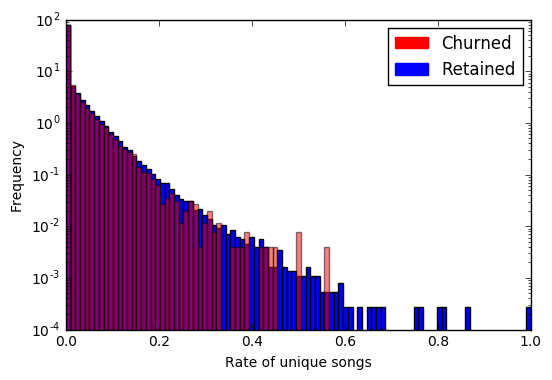

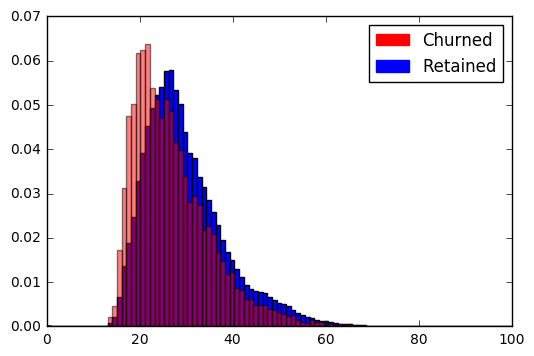

In [43]:
bins = np.linspace(0, 1, 100)
plt.hist(usezchurn['rate_unq'],bins,color='blue',normed=True)
plt.hist(useochurn['rate_unq'],bins,color='red',alpha=0.5,normed=True)
plt.xlabel('Rate of unique songs')
plt.ylabel('Frequency')
plt.yscale('log')
red_patch = mpatches.Patch(color='red', label='Churned')
blue_patch = mpatches.Patch(color='blue', label='Retained')
plt.legend(handles=[red_patch,blue_patch])
plt.show()

bins = np.linspace(0, 100, 100)
plt.hist(rmbadbdtrainzchurn['bd'],bins,color='blue',normed=True)
plt.hist(rmbadbduseochurn['bd'],bins,color='red',normed=True,alpha=0.5)
red_patch = mpatches.Patch(color='red', label='Churned')
blue_patch = mpatches.Patch(color='blue', label='Retained')
plt.legend(handles=[red_patch,blue_patch])
plt.show()


In [25]:
print(stats.ttest_ind(rmbadbdtrainzchurn['bd'], rmbadbdusezchurn['bd'], axis=0, equal_var=False))
print(stats.ttest_ind(rmbadbdtrainochurn['bd'], rmbadbduseochurn['bd'], axis=0, equal_var=False))

Ttest_indResult(statistic=1.2132513787606181, pvalue=0.22503458350170683)
Ttest_indResult(statistic=0.75579731882132661, pvalue=0.44977621957522385)
